# Agenda
*   Build a BERT pipeline for classification using an ML model and a pretrained BERT model for feature.
*   Compare results with classical feature transformation(extraction) techniques



In [1]:
%%capture
!pip install pytorch_pretrained_bert

In [2]:
!pip install transformers

In [3]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from pytorch_pretrained_bert import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preperation

In [5]:
# Download the dataset
!gdown --id 1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL
To: /content/in_domain_train.tsv
100% 429k/429k [00:00<00:00, 159MB/s]


In [6]:
# Read into a pandas dataframe
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])[['label', 'sentence']]
df

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.
...,...,...
8546,0,Poseidon appears to own a dragon
8547,0,Digitize is my happiest memory
8548,1,It is easy to slay the Gorgon.
8549,1,I had the strangest feeling that I knew you.


In [7]:
# Sample data
sentences = df["sentence"].values
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
X_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
y_labels = df["label"].values

# Bert tokenization
Apply bert tokenizer over each sentence

In [8]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 905760.33B/s]


In [9]:
tokenized_texts = []
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in X_sentences]

In [10]:
input_ids = []
# Convert the tokens to their index numbers (input_ids) in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Create the attnetion mask

In [11]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [12]:
# Convert the ids into a tensor representation
batch_size = 8
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)

# Bert model
Initialize the bert model and feed in all the sentences to get the encoded vectors

In [13]:
# Initialize the model
model = BertModel.from_pretrained("bert-base-uncased").to('cuda')

100%|██████████| 407873900/407873900 [00:11<00:00, 36576479.60B/s]


In [18]:
# Evaluate and collect embeddings
model.eval()
outputs = []
for input, masks in dataloader:
    torch.cuda.empty_cache()  # empty the GPU memory

    # Transfer the batch to GPU
    input = input.to('cuda')
    masks = masks.to('cuda')

    # Run inference on the batch
    with torch.no_grad():
        outputs_tuple = model(input, attention_mask=masks)
        hidden_states = outputs_tuple[0]  # Extract hidden states from the output tuple

        # Extract the CLS token embeddings from the last hidden state
        cls_embeddings = hidden_states[-1][:, 0, :]  # shape: (batch_size, hidden_size)
        outputs.append(cls_embeddings.cpu().numpy())


# Your turn
1.   Aggregate the encoded represntation (use mean)
2.   Apply a classical transformation of your choice (BOW - TFIDF - word2vec - etc...), you can use the bert tokenizer.
3.   Plot 2 T-sne plots, one for both representations and comment.
4. Apply an ML model of your choice over both representations and comment.



**Aggrigation**

In [21]:
# Aggregate the encoded representations using CLS Token

# Concatenate all CLS embeddings into a single numpy array
cls_embeddings = np.concatenate(outputs, axis=0)


CLS embeddings shape: (8551, 768)


**Apply a classical transformation "TFIDF"**

In [22]:
# Convert tokenized texts to sentences
sentences = [" ".join(tokens) for tokens in tokenized_texts]

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the sentences
tfidf_representation = tfidf_vectorizer.fit_transform(sentences).toarray()

**Compaire Representations to Bert vs TFIDF**

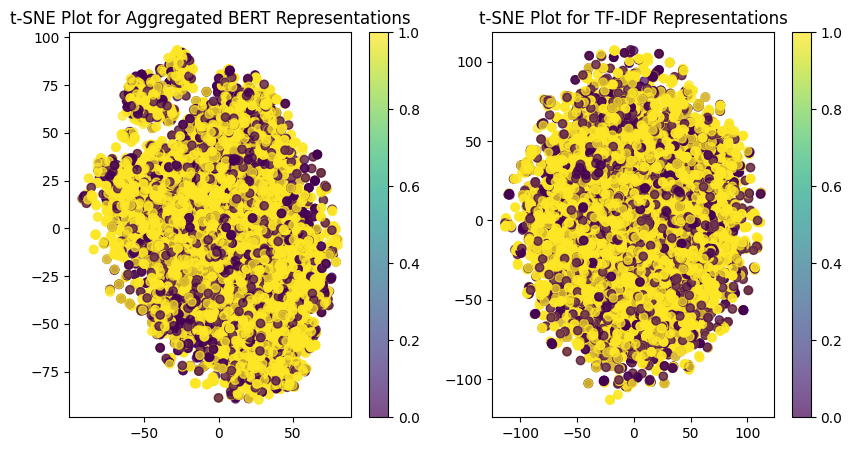

In [23]:
# Use t-SNE to reduce the dimensionality of BERT representations and TF-IDF representations and then plot them for visualization.

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE on aggregated BERT representations
tsne_bert = tsne.fit_transform(cls_embeddings)

# Apply t-SNE on TF-IDF representations
tsne_tfidf = tsne.fit_transform(tfidf_representation)

# Plot t-SNE for aggregated BERT representations
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_bert[:, 0], tsne_bert[:, 1], c=y_labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE Plot for Aggregated BERT Representations')
plt.colorbar()

# Plot t-SNE for TF-IDF representations
plt.subplot(1, 2, 2)
plt.scatter(tsne_tfidf[:, 0], tsne_tfidf[:, 1], c=y_labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE Plot for TF-IDF Representations')
plt.colorbar()

plt.show()


**Apply an ML model "Logistic Regression" & "Neural Network" before Fine Tuning**


#Logistic Regression before fine tuning

Preprocess the data:

In [29]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cls_embeddings, y_encoded, test_size=0.2, random_state=42)

Train the model:

In [30]:
# Train Logistic Regression model

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Evaluate the model:

In [32]:
# Evaluate the model

accuracy_LR = logistic_regression.score(X_test, y_test)
print("Accuracy after hyperparameter tuning:", accuracy_LR)

Accuracy after hyperparameter tuning: 0.7638807714786674


#Neural Network before fine tuning

Preprocess the data:

In [33]:
# Data preprocessing using TF-IDF vectorization and label encoding.

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_NN_train, X_NN_test, y_NN_train, y_NN_test = train_test_split(cls_embeddings, y_categorical, test_size=0.2, random_state=42)

Build the neural network model:

In [34]:
# Building a neural network with Dropout regularization.

NN_model = Sequential()
NN_model.add(Dense(128, input_shape=(X_NN_train.shape[1],), activation='relu'))
NN_model.add(Dropout(0.5))  # Increase dropout rate
NN_model.add(Dense(64, activation='relu'))
NN_model.add(Dropout(0.5))  # Increase dropout rate
NN_model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss
NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Train the model:

In [35]:
# Implement Early Stopping callback to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping callback
history = NN_model.fit(X_NN_train, y_NN_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
171/171 [==============================] - 7s 7ms/step - loss: 0.6275 - accuracy: 0.6791 - val_loss: 0.5581 - val_accuracy: 0.7222
Epoch 2/20
171/171 [==============================] - 1s 7ms/step - loss: 0.5660 - accuracy: 0.7177 - val_loss: 0.5388 - val_accuracy: 0.7354
Epoch 3/20
171/171 [==============================] - 1s 6ms/step - loss: 0.5469 - accuracy: 0.7378 - val_loss: 0.5354 - val_accuracy: 0.7281
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.5367 - accuracy: 0.7401 - val_loss: 0.5465 - val_accuracy: 0.7500
Epoch 5/20
171/171 [==============================] - 1s 4ms/step - loss: 0.5214 - accuracy: 0.7460 - val_loss: 0.5203 - val_accuracy: 0.7515
Epoch 6/20
171/171 [==============================] - 1s 4ms/step - loss: 0.5143 - accuracy: 0.7524 - val_loss: 0.5267 - val_accuracy: 0.7515
Epoch 7/20
171/171 [==============================] - 1s 4ms/step - loss: 0.5085 - accuracy: 0.7555 - val_loss: 0.5181 - val_accuracy: 0.7507
Epoch 

Evaluate the model:

In [36]:
# Evaluating the model's performance on the test set.

loss, accuracy_NN = NN_model.evaluate(X_NN_test, y_NN_test)
print("Accuracy after training neural network:", accuracy_NN)

54/54 [==============================] - 0s 3ms/step - loss: 0.5052 - accuracy: 0.7785
Accuracy after training neural network: 0.7784920930862427


#Fine Tuning

Load Pre-trained BERT Model and Tokenizer

In [37]:
# Load pre-trained BERT model and tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Split the Data into Training and Testing Sets

In [38]:
# Split the data into training and testing sets

X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(X_sentences, y_labels, test_size=0.2, random_state=42)

Tokenize Input Sentences and Format Them as Tensors

In [39]:
from transformers import BertTokenizer
# Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input sentences and format them as tensors
def tokenize_data(sentences, labels):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels_tensor = torch.tensor(labels)
    return input_ids, attention_masks, labels_tensor

# Tokenize training and testing data
train_inputs, train_masks, train_labels = tokenize_data(X_train_FT, y_train_FT)
test_inputs, test_masks, test_labels = tokenize_data(X_test_FT, y_test_FT)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Create Data Loaders

In [40]:
# Create data loaders

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Fine-tune BERT

In [41]:
# Fine-tune BERT

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 4
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    torch.cuda.empty_cache()

    model.eval()
    val_accuracy = 0
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        val_accuracy += accuracy_score(label_ids, np.argmax(logits, axis=1))
    avg_val_accuracy = val_accuracy / len(test_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}, Validation Accuracy: {avg_val_accuracy}')

# Rename the fine-tuned model for clarity
FT_model = model

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Training Loss: 0.5046160326939877, Validation Accuracy: 0.8069058641975309
Epoch 2/4, Training Loss: 0.3020546321591763, Validation Accuracy: 0.8284722222222222
Epoch 3/4, Training Loss: 0.19866760935042507, Validation Accuracy: 0.8313657407407407
Epoch 4/4, Training Loss: 0.15141526547425957, Validation Accuracy: 0.8192129629629629


Save Fine Tuning model

In [43]:
from transformers import BertForSequenceClassification

# Assuming 'model' is your trained BERT model
FT_model.save_pretrained('/content/drive/MyDrive/Fine_Tuning_Model')

When we want to load the model, just remove the comment ' ' ' at the top and bottom and then run the code and continue

In [ ]:
'''
from transformers import BertForSequenceClassification

# Load the fine-tuned model
FT_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Fine_Tuning_Model')

# Ensure the model is in evaluation mode
FT_model.eval()
'''

Collects the hidden state outputs of BERT for each input in the dataset

In [44]:
# DataLoader after Fine Tuning
FT_model.eval()
FT_outputs = []

for input, masks in dataloader:
    torch.cuda.empty_cache()  # Empty the GPU memory

    # Transfer the batch to GPU
    input = input.to('cuda')
    masks = masks.to('cuda')

    # Run inference on the batch
    output = FT_model.bert.forward(input, output_attentions=True, attention_mask=masks, output_hidden_states=True)[0]
    # Transfer the output to CPU again and convert to numpy
    output = output.cpu().detach().numpy()

    # Store the output in a list
    FT_outputs.append(output)

# Concatenate all the arrays within the list into one array
FT_outputs = np.concatenate(FT_outputs, axis=0)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [45]:
np.shape(FT_outputs)

(8551, 128, 768)

#Aggrigation after Fine Tuning


In [47]:
# Aggregate by CLS token representation (first token of each sequence)

FT_cls_embeddings = FT_outputs[:, 0, :]

#Apply a classical transformation "TFIDF"

In [48]:
# Convert tokenized texts to sentences
sentences = [" ".join(tokens) for tokens in tokenized_texts]

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the sentences
tfidf_representation = tfidf_vectorizer.fit_transform(sentences).toarray()

#Compaire Representations to Fine_Tunig_Bert vs TFIDF

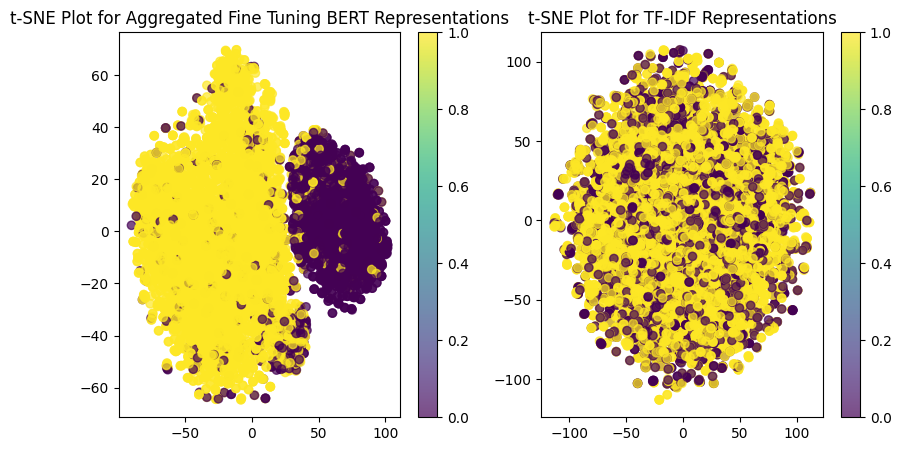

In [49]:
# Use t-SNE to reduce the dimensionality of BERT representations and TF-IDF representations and then plot them for visualization.

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE on aggregated Fine Tuning BERT representations
tsne_fine_tuning_bert = tsne.fit_transform(FT_cls_embeddings)

# Apply t-SNE on TF-IDF representations
tsne_tfidf = tsne.fit_transform(tfidf_representation)


# Plot t-SNE for aggregated BERT representations
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_fine_tuning_bert[:, 0], tsne_fine_tuning_bert[:, 1], c=y_labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE Plot for Aggregated Fine Tuning BERT Representations')
plt.colorbar()

# Plot t-SNE for TF-IDF representations
plt.subplot(1, 2, 2)
plt.scatter(tsne_tfidf[:, 0], tsne_tfidf[:, 1], c=y_labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE Plot for TF-IDF Representations')
plt.colorbar()

plt.show()


#**Apply an ML model "Logistic Regression" & "Neural Network" before Fine Tuning**


**Logistic Regression after fine tuning**

Split the Data after aggregate fine_tuning_results

In [50]:
# Split the BERT embeddings and labels into training and test sets
X_train_fine_tuning_bert, X_test_fine_tuning_bert, y_train_fine_tuning_bert, y_test_fine_tuning_bert = train_test_split(
    FT_cls_embeddings, y_labels, test_size=0.2, random_state=42
)

Train Logistic Regression Model

In [51]:
# Train Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_fine_tuning_bert, y_train_fine_tuning_bert)

LogisticRegression(max_iter=1000)

Evaluate the Model

In [52]:
# Evaluate the model
accuracy_fine_tuning = logistic_regression.score(X_test_fine_tuning_bert, y_test_fine_tuning_bert)
print("Accuracy after hyperparameter tuning:", accuracy_fine_tuning)

Accuracy after hyperparameter tuning: 0.8164815897136177


**Neural Network after fine tuning**

Preprocess the data:

In [53]:
# Data preprocessing using TF-IDF vectorization and label encoding.

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_NN_train_FT, X_NN_test_FT, y_NN_train_FT, y_NN_test_FT = train_test_split(FT_cls_embeddings, y_categorical, test_size=0.2, random_state=42)

Build the neural network model:

In [54]:
# Building a neural network with Dense layers and Dropout for regularization.

FT_NN_model = Sequential()
FT_NN_model.add(Dense(128, input_shape=(X_NN_train_FT.shape[1],), activation='relu'))
FT_NN_model.add(Dropout(0.5))
FT_NN_model.add(Dense(64, activation='relu'))
FT_NN_model.add(Dropout(0.5))
FT_NN_model.add(Dense(y_categorical.shape[1], activation='softmax'))

FT_NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Train the model:

In [55]:
# Compiling and training the model.

history = FT_NN_model.fit(X_NN_train_FT, y_NN_train_FT, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
171/171 [==============================] - 2s 5ms/step - loss: 0.1364 - accuracy: 0.9678 - val_loss: 0.0743 - val_accuracy: 0.9766
Epoch 2/20
171/171 [==============================] - 1s 4ms/step - loss: 0.1114 - accuracy: 0.9744 - val_loss: 0.0686 - val_accuracy: 0.9788
Epoch 3/20
171/171 [==============================] - 1s 4ms/step - loss: 0.1031 - accuracy: 0.9740 - val_loss: 0.0765 - val_accuracy: 0.9788
Epoch 4/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0985 - accuracy: 0.9781 - val_loss: 0.0698 - val_accuracy: 0.9788
Epoch 5/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0888 - accuracy: 0.9781 - val_loss: 0.0686 - val_accuracy: 0.9803
Epoch 6/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0869 - accuracy: 0.9775 - val_loss: 0.0723 - val_accuracy: 0.9788
Epoch 7/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0895 - accuracy: 0.9792 - val_loss: 0.0675 - val_accuracy: 0.9781
Epoch 

Evaluate the model:

In [56]:
# Evaluating the model's performance on the test set.

loss, accuracy_tfidf = FT_NN_model.evaluate(X_NN_test_FT, y_NN_test_FT)
print("Accuracy after training neural network:", accuracy_tfidf)

54/54 [==============================] - 0s 3ms/step - loss: 0.9978 - accuracy: 0.8258
Accuracy after training neural network: 0.8258328437805176
